In [1]:
import thermoTools
import thermoToolsAdditions as tta
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import copy

<!-- <div hidden> -->
$\usepackage{biblatex}
\aaddbibresource{references.bib}$
<!-- </div> -->

### Example 1: Standalone Thermochimica
This is an example of running a standalone thermochimica calculation for a series of temperatures

In [2]:
dataFile = Path("data/MSTDB-TC_V3.0_Chlorides_No_Functions_8-2.dat")
scriptName = "test"
elements = ['Na', 'Cl', 'Mg', 'Pu']

component_fractions = {'Na Cl': 0.8, 'Mg Cl_2': 0.1, 'Pu Cl_3': 0.1}

tstart = 1500
tend = 2000
ntstep = 20
pstart = 1
pend = 1
npstep = 1
masses = tta.component_fractions_to_element_fractions(component_fractions, elements)

print(masses)

# Write an input script
thermoTools.WriteInputScript(scriptName, str(dataFile), elements, tstart, tend, ntstep, pstart, pend, npstep, masses, heatCapacity=True)

# Run an input script
thermochimicaPath = Path("/home/mlouis9/thermochimica")
outputPath = Path("../../PythonProjects/fuelOptimization/outputs")
outputName = "output.json"

thermoTools.RunInputScript(scriptName, jsonName=str(outputPath / outputName), thermochimica_path=str(thermochimicaPath), noOutput=True)

[0.8, 1.3, 0.1, 0.1]


### Example 2: Solubility Calculation
This is an example solubility calculation for $\text{PuCl}_3$ in the eutectic salt $x(\text{LiCl}):x(\text{KCl}) = (0.586:0.414)$ 

In [3]:
# File IO input parameters
thermochimica_path = Path("/home/mlouis9/thermochimica")
output_path = Path("../../PythonProjects/fuelOptimization/outputs")
output_name = "output.json"
data_file = Path("data/MSTDB-TC_V3.0_Chlorides_No_Functions_8-2.dat")
script_name = "test"

# Physical parameters
temp = 723
press = 1
unit_ratio_of_other_components = {'Li Cl': 0.586, 'K Cl': 0.414}
component_to_vary = 'Pu Cl_3'
compstart = 0.01
compstop = 0.4
n_comp_step = 20
calc = tta.solubility_calculation(temp, press, unit_ratio_of_other_components, component_to_vary, n_comp_step, \
                       thermochimica_path, output_path, output_name, data_file, compstart=compstart, compstop=compstop, fuzzy=True)

In [4]:
# calc.mole_fraction_element_by_phase['Pu']
list(calc.output.values())[0]['# pure condensed phases']

1

In [5]:
calc.stable_phases

[[('MSCL', 2.02), ('K3PuCl6_S1(s)', 0.00202)],
 [('MSCL', 2.061052631578947), ('K3PuCl6_S1(s)', 0.02249913156255506)],
 [('MSCL', 2.1021052631578945), ('K3PuCl6_S1(s)', 0.0421985374011967)],
 [('MSCL', 1.8642997732642308),
  ('FM3M', 0.11185953651400367),
  ('K3PuCl6_S1(s)', 0.06400232444862858)],
 [('MSCL', 1.081492945212058),
  ('FM3M', 0.28245637018505065),
  ('K3PuCl6_S1(s)', 0.08771001324492728)],
 [('MSCL', 0.29868616727570746),
  ('FM3M', 0.4530532015091696),
  ('K3PuCl6_S1(s)', 0.11141769648959488)],
 [('FM3M', 0.48364939303204035),
  ('K2PuCl5_S1(s)', 0.04173620319142364),
  ('K3PuCl6_S1(s)', 0.09142169154533476)],
 [('FM3M', 0.4970493234880382),
  ('K2PuCl5_S1(s)', 0.11178616559330151),
  ('K3PuCl6_S1(s)', 0.0418980449330143)],
 [('MSCL', 0.07781386107717402),
  ('FM3M', 0.4694934700922297),
  ('K2PuCl5_S1(s)', 0.16520260288931826)],
 [('MSCL', 0.6485434157840332),
  ('FM3M', 0.3501553113438365),
  ('K2PuCl5_S1(s)', 0.11965986546445742)],
 [('MSCL', 1.2192730053438372),
  ('F

In [6]:
calc.output['20']['elements']

{'Pu': {'moles': 0.4000000000000001, 'element potential': -50050.47773205744},
 'K': {'moles': 0.24839999999999998, 'element potential': -190360.38572171322},
 'Cl': {'moles': 1.8000000000000003, 'element potential': -349754.87584552314},
 'Li': {'moles': 0.3516, 'element potential': -115381.02742892805}}

### Example 3
Calculate reference pseudo-binary phase diagrams for each of the constituient binary subsystems of the ternary chloride salt $\text{LiCl-KCl-PuCl}_3$ these are to be compared with (zhou2017thermodynamic)

In [7]:
import pseudoBinaryPhaseDiagramFunctions as pbpd


# File IO input parameters
thermochimica_path = Path("/home/mlouis9/thermochimica")
output_path = Path("../../PythonProjects/fuelOptimization/outputs")
output_name = 'output.json'
data_file = Path("data/MSTDB-TC_V3.0_Chlorides_No_Functions_8-2.dat")
input_file_name = "runThermochimica.ti"

# Physical input parameters
press = 1
tunit = 'K'
punit = 'atm'
elements_used = ['Li', 'Cl', 'K']

# Now get elemental compositions of endmembers
left_endmember_composition = {'Li Cl': 1.0}
right_endmember_composition = {'K Cl': 1.0}
left_endmember_masses = tta.component_fractions_to_element_fractions(left_endmember_composition, elements_used)
right_endmember_masses = tta.component_fractions_to_element_fractions(right_endmember_composition, elements_used)

sum1 = sum(left_endmember_masses)
sum2 = sum(right_endmember_masses)

mass_labels = tta.get_mass_labels(left_endmember_masses, right_endmember_masses, elements_used)

# Now normalize left and right endmember masses, NOTE this is REQUIRED for the plotting and postprocessing to behave
left_endmember_masses = list( left_endmember_masses / sum1 )
right_endmember_masses = list( right_endmember_masses / sum2 )

plane = [left_endmember_masses, right_endmember_masses]

munit = 'moles'

if tunit == 'K':
    tshift = 0
elif tunit == 'C':
    tshift = 273.15
else:
    assert(f"Invalid temperature unit \'{tunit}\' provided")

xlo = 0
xhi = 1
nxstep = 50
tlo = 500
thi = 1200
mint = tlo + tshift
maxt = thi + tshift
ntstep = 50

calc = pbpd.diagram(data_file, active=True, interactivePlot=True, inputFileName='runThermochimica.ti', \
                    outputFileName=str(output_path / output_name), thermochimicaPath=thermochimica_path)

calc.initRun(press, tunit, punit, plane, sum1, sum2, mint, maxt, elements_used, mass_labels, munit, tshift, fuzzy=True)
calc.runCalc(xlo, xhi, nxstep, tlo, thi, ntstep)
calc.processPhaseDiagramData()

Thermochimica calculation initiated.
Thermochimica calculation finished.


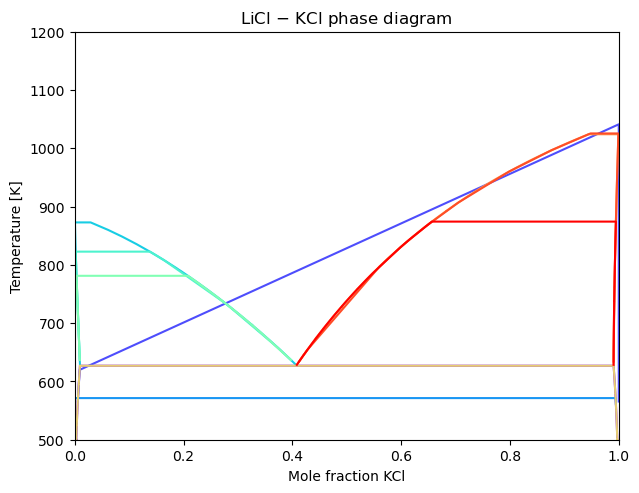

In [8]:
calc.makePlot()